# Quantum states with high dimensional entanglement

This notebook allows visualizing the 20 circuits of the second pilot study with mention of their depth and gate repartition.

At the end, a toy protocol of ballot transmission is presented with experimental verification.

In [1]:
import numpy as np
import copy
from qiskit import QuantumRegister, QuantumCircuit, ClassicalRegister, Aer, execute, transpile, assemble
from qiskit.tools.visualization import *
from qiskit.ignis.mitigation.measurement import (complete_meas_cal, tensored_meas_cal,
                                                 CompleteMeasFitter, TensoredMeasFitter)
import json
import time
from qiskit.tools.monitor import job_monitor
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt

In [2]:
from c_utils import new_cut # circuit building utilities
from o_utils import ora

In [3]:
data_directory = "data2_files/" # this directory for 2d pilot project data
def json_dic_loader(dic_name):
    f = open(data_directory+dic_name+'.json')
    return json.load(f)
def json_dic_dumper(dic, dic_name):
    with open(data_directory+dic_name+'.json', 'w') as f:
        json.dump(dic,f)   

## Set up the simulator and layout for 5 qubits

In [4]:
simulator = Aer.get_backend('qasm_simulator')

In [5]:
#specify the layout of the devices
used_qubits = 5
qubit_list = [0,1,2,3,4]

In [6]:
program_name="AL2" # This for a mix of W/Psi+ and W_bar/Phi+ separable states (2d pilot project)
Flag_char = "DS" # use the joint set
if len(Flag_char) >= 2:
    unique_char = "M" # for "mixed"
else:
    unique_char = Flag_char

###### OLD VERSION TO BE DELETED These dictionaries for the devices used in the study
QV_dic = {'ibmq_athens': 32.0, 'ibmq_valencia': 16.0, 'ibmq_ourense': 8.0, 
          "ibmqx2": 8.0, 'ibmq_santiago': 32.0, 'ibmq_vigo': 16.0, 'ideal_device': np.inf}
dev_dic =  {'ibmq_santiago': "San",'ibmq_athens': "Ath", 'ibmq_valencia': "Val", 'ibmq_vigo': 'Vig','ibmq_ourense': "Our",
               "ibmqx2": 'Yor',  'ideal_device': "Ide"}

In [52]:
# These dictionaries for the devices used in the study
if program_name == "QAD":
    fidelity_dic = {'ibmq_athens': 0.925110, 'ibmq_valencia': 0.809101, 'ibmq_ourense': 0.802380,"ibmqx2": 0.627392, 
                    'ibmq_santiago': 0.919399, 'ibmq_vigo': 0.908840, 'ibmq_lima':0.771835, 'ideal_device': 1.0}
    data_directory = "data_files/"
elif program_name == "AL2":
    fidelity_dic = {'ibmq_athens': 0.910145, 'ibmq_valencia': 0.794262, 'ibmq_ourense': 0.818974, "ibmqx2": 0.359528,
                    'ibmq_santiago': 0.900024, 'ibmq_vigo': 0.841831, 'ibmq_quito': 0.840260, 'ibmq_lima':0.771835,
                    'ibmq_belem':0.842281,'ideal_device': 1.0}
    data_directory = "data2_files/"
QV_dic = {'ibmq_athens': 32.0, 'ibmq_valencia': 16.0, 'ibmq_ourense': 8.0,"ibmqx2": 8.0, 'ibmq_santiago': 32.0,
          'ibmq_vigo': 16.0, 'ideal_device': np.inf,  'ibmq_quito': 16.0, 'ibmq_lima': "Lim",'ibmq_belem':16.0}
dev_dic =  {'ibmq_santiago': "San",'ibmq_athens': "Ath", 'ibmq_valencia': "Val", 'ibmq_vigo': 'Vig','ibmq_ourense': "Our",
               "ibmqx2": 'Yor', 'ibmq_quito': "Qui", 'ibmq_lima': "Lim", 'ibmq_belem': "Bel",'ideal_device': "Ide" }

In [8]:
# specify the device: here first the ideal noise-free device
project_device = 'ideal_device'
device_name = dev_dic[project_device]

In [9]:
# specify the nb of id gates between state creation and measurements
# zero for the ideal device of course
id_gates = 0
str_nb_id = str(id_gates)
zfilled = str_nb_id.zfill(4-len(str_nb_id))

In [10]:
# tail of the file names for RAM storage
mitig_name = program_name + "_" + device_name
project_name = mitig_name + "_" + unique_char + zfilled
print(mitig_name)
print(project_name)

AL2_Ide
AL2_Ide_M000


In [11]:
# establish the result label list
# meas_calibs will be used for mitigation in the real device section
qr = QuantumRegister(used_qubits) # 
meas_calibs, label_list = complete_meas_cal(qubit_list=qubit_list, qr=qr, circlabel='mcal')
nb_labels=len(label_list)
print(nb_labels,label_list)

32 ['00000', '00001', '00010', '00011', '00100', '00101', '00110', '00111', '01000', '01001', '01010', '01011', '01100', '01101', '01110', '01111', '10000', '10001', '10010', '10011', '10100', '10101', '10110', '10111', '11000', '11001', '11010', '11011', '11100', '11101', '11110', '11111']


In [12]:
len(meas_calibs)

32

In [13]:
# permutation list
# here it is simple to write down the list, 
# but a version using itertools will be wellcome for >5 qubits projects
q_perm = [[0, 1, 2, 3, 4], [0, 1, 3, 2, 4], [0, 1, 4, 2, 3], [0, 2, 3, 1, 4], [0, 2, 4, 1, 3],
          [0, 3, 4, 1, 2], [1, 2, 3, 0, 4], [1, 2, 4, 0, 3], [1, 3, 4, 0, 2], [2, 3, 4, 0, 1]]

## Create the quantum states


In [14]:
# define the two subsets of 10 separable states
if program_name == "QAD":
    state_1a = ["W","Phi+"]
    state_1b = ["GHZ","Psi+"]
elif program_name == "ALT" or "AL2":
    state_1a = ["W","Psi+"]
    state_1b = ["Wbar","Phi+"]
l_states = state_1a+state_1b

In [15]:
l_states

['W', 'Psi+', 'Wbar', 'Phi+']

In [16]:
# version 20 circuits for demonstration
# (in the version run on real devices: two batches of 10 circuits)

# these circuits limited to state creation are ready to be saved 
# for  ultimately building circuits adapted to noisy simulator and real devices
# as option, these circuits will include a row of id gates between creation and measurements

circ_ori = []
for i_s in range(0,len(l_states),2):
    for perm in q_perm:
            mycircuit = QuantumCircuit(used_qubits, used_qubits)                                   
            mycircuit = new_cut.circuit_builder(mycircuit, perm, l_states[i_s],l_states[i_s+1])
            circ_ori.append(mycircuit)

In [17]:
# add measurement section to the circuit set newly created:
nb_states = len(circ_ori)
circ_ideal = copy.deepcopy(circ_ori)
for i_state in range(nb_states):
    new_cut.add_barrier_and_measure(circ_ideal[i_state],qubit_list)

## Obtain result distributions on  noise free simulator

In [18]:
# execute on noise free simulator  
s_sim = 12000
job_simul = execute(circ_ideal, backend=simulator, shots=s_sim)
tot_results_simul = job_simul.result()

In [19]:
# establish a dictionary of count results on noise free simulator:
# (this step is only useful if ram storage is performed)
void_counts = dict(zip(label_list, np.full(2**used_qubits,0.0))) #, dtype=int)))
tot_results_sim_dic = {}
ideal_dic = {}
for i_state in range(nb_states):
    counts_simul = copy.deepcopy(void_counts)
    counts_simul.update(tot_results_simul.get_counts(i_state))
    ideal_dic[str(i_state)]=counts_simul

Example of circuit for separable state of the first type : $|W\rangle\otimes|\Psi^+\rangle$

Ide circuit # 1


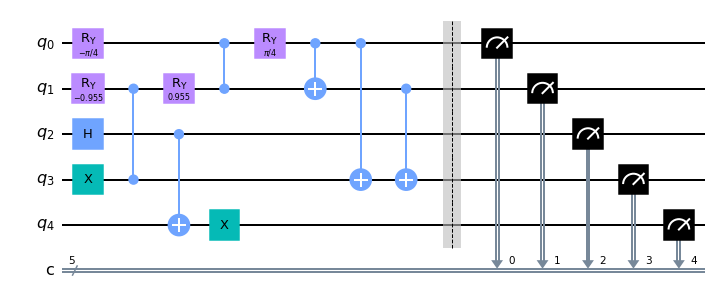

In [20]:
i_state_test = 1
print(device_name, "circuit #",i_state_test)
circ_ideal[i_state_test].draw(output='mpl')

Ide circuit # 1


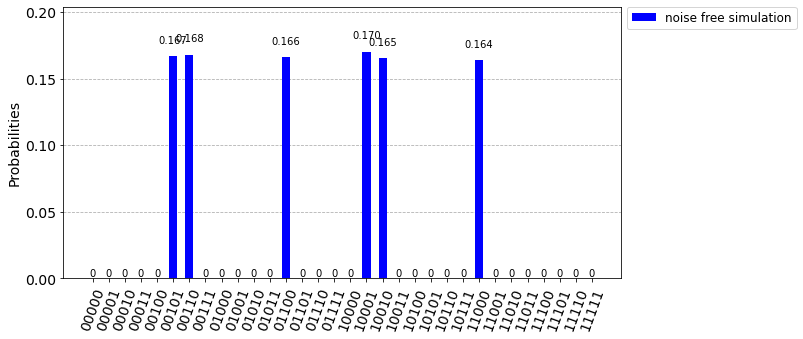

In [21]:
print(device_name, "circuit #",i_state_test)
plot_histogram(ideal_dic[str(i_state_test)],
               legend=['noise free simulation'],
               color = "b", figsize=(10.,5.))

Example of circuit for separable state of the second type : $|W\rangle^{\otimes X}\otimes|\Phi^+\rangle$

Ide circuit # 11


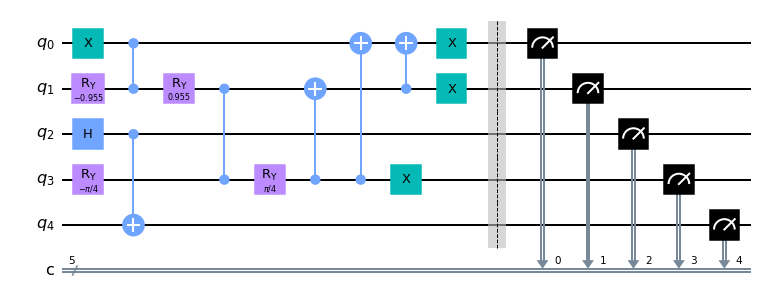

In [22]:
i_state_test = 11
print(device_name, "circuit #",i_state_test)
circ_ideal[i_state_test].draw(output='mpl')

Ide circuit # 11


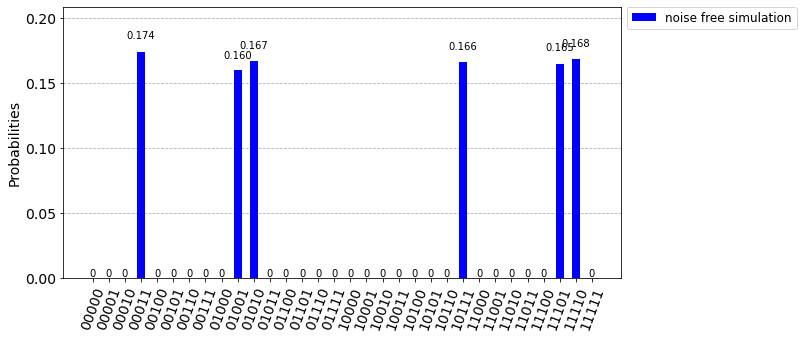

In [23]:
print(device_name, "circuit #",i_state_test)
plot_histogram(ideal_dic[str(i_state_test)],
               legend=['noise free simulation'],
               color = "b", figsize=(10.,5.))

### Obtain the matrix of probability distribution of shape(nb_state,nb_labels) used by the classifier

In [24]:
def print_first_and_last_row(PDM):
    print("first and last rows of the probability distribution matrix of dimension "+str(nb_states)+"x"+str(nb_labels))
    print(np.round(PDM[0:1,:],4))
    print("   ...")
    print(np.round(PDM[-1:,:],4))

In [25]:
PD_ideal =  np.ndarray((nb_states,nb_labels))
for i_state in range(nb_states):
    PD_ideal[i_state, :] = list(ideal_dic[str(i_state)].values())
# now a little trick to get the ideal values from the simulator approximated values
with np.errstate(divide='ignore'): # ignore the divide by zero warning
    PD_ideal = 1/np.round(s_sim/(PD_ideal))
# have a look at the matrix head and tail:
print_first_and_last_row(PD_ideal)

first and last rows of the probability distribution matrix of dimension 20x32
[[0.     0.     0.     0.     0.     0.     0.     0.     0.     0.1667
  0.1667 0.     0.1667 0.     0.     0.     0.     0.1667 0.1667 0.
  0.1667 0.     0.     0.     0.     0.     0.     0.     0.     0.
  0.     0.    ]]
   ...
[[0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
  0.     0.     0.1667 0.     0.     0.1667 0.     0.     0.     0.
  0.1667 0.     0.     0.1667 0.1667 0.     0.     0.1667 0.     0.
  0.     0.    ]]


# Real device section

In [26]:
from qiskit import IBMQ

In [27]:
IBMQ.load_account()

C:\Users\decpi\Anaconda3\envs\QK20\lib\site-packages\qiskit\providers\ibmq\ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [28]:
provider = IBMQ.get_provider(hub='ibm-q')

In [29]:
print(provider.backends())

[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQBackend('ibmqx2') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQBackend('ibmq_16_melbourne') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQBackend('ibmq_armonk') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQBackend('ibmq_athens') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQBackend('ibmq_santiago') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQBackend('ibmq_lima') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQBackend('ibmq_belem') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQBackend('ibmq_quito') from IBMQ(hub='ibm-q', group='open', project='main')>]


In [30]:
project_device = 'ibmq_quito'# you may choice here a different backend
device_name = dev_dic[project_device]
mitig_name = program_name + "_" + device_name
print(mitig_name)

AL2_Qui


In [31]:
# determine here the backend
device = provider.get_backend(project_device) # the backend names are listed here above
properties = device.properties()
coupling_map = device.configuration().coupling_map

### Load circuits run on real device
 

In [32]:
id_gates = 0 # choice of 0 or 256 at this time
str_nb_id = str(id_gates)
zfilled = str_nb_id.zfill(4-len(str_nb_id))
project_name = mitig_name + "_" + unique_char + zfilled
print(project_name)

AL2_Qui_M000


In [33]:
circuit_dic = json_dic_loader("circuit_"+ project_name)

In [34]:
real_circs = []
for i_state in list(range(nb_states)): 
    real_circs.append(QuantumCircuit().from_qasm_str(circuit_dic[str(i_state)]))  

In [35]:
for i_state in range(20): 
    print(i_state,
            "depth",real_circs[i_state].depth(),
            "size", real_circs[i_state].size(),
            "cx",real_circs[i_state].num_nonlocal_gates(),
            json.dumps(real_circs[i_state].count_ops()))

0 depth 54 size 87 cx 9 {"rz": 34, "sx": 33, "cx": 9, "measure": 5, "u1": 4, "x": 2, "barrier": 1}
1 depth 67 size 97 cx 18 {"rz": 36, "sx": 33, "cx": 18, "measure": 5, "u1": 3, "x": 2, "barrier": 1}
2 depth 59 size 96 cx 16 {"rz": 38, "sx": 33, "cx": 16, "measure": 5, "x": 2, "u1": 2, "barrier": 1}
3 depth 57 size 93 cx 15 {"rz": 34, "sx": 33, "cx": 15, "measure": 5, "u1": 4, "x": 2, "barrier": 1}
4 depth 69 size 99 cx 20 {"rz": 36, "sx": 33, "cx": 20, "measure": 5, "u1": 3, "x": 2, "barrier": 1}
5 depth 56 size 92 cx 14 {"rz": 34, "sx": 33, "cx": 14, "measure": 5, "u1": 4, "x": 2, "barrier": 1}
6 depth 54 size 95 cx 16 {"rz": 36, "sx": 33, "cx": 16, "measure": 5, "u1": 3, "x": 2, "barrier": 1}
7 depth 60 size 97 cx 17 {"rz": 38, "sx": 33, "cx": 17, "measure": 5, "x": 2, "u1": 2, "barrier": 1}
8 depth 53 size 93 cx 14 {"rz": 36, "sx": 33, "cx": 14, "measure": 5, "u1": 3, "x": 2, "barrier": 1}
9 depth 58 size 94 cx 16 {"rz": 34, "sx": 33, "cx": 16, "measure": 5, "u1": 4, "x": 2, "barri

In [36]:
i_state_test = 11 # choose here a perticular state to study

In [37]:
print(project_device, "circuit #",i_state_test,
      "circuit depth:",real_circs[i_state_test].depth())
print('gates = ',real_circs[i_state_test].count_ops())

ibmq_quito circuit # 11 circuit depth: 70
gates =  OrderedDict([('rz', 38), ('sx', 33), ('cx', 22), ('measure', 5), ('x', 4), ('u1', 2), ('barrier', 1)])


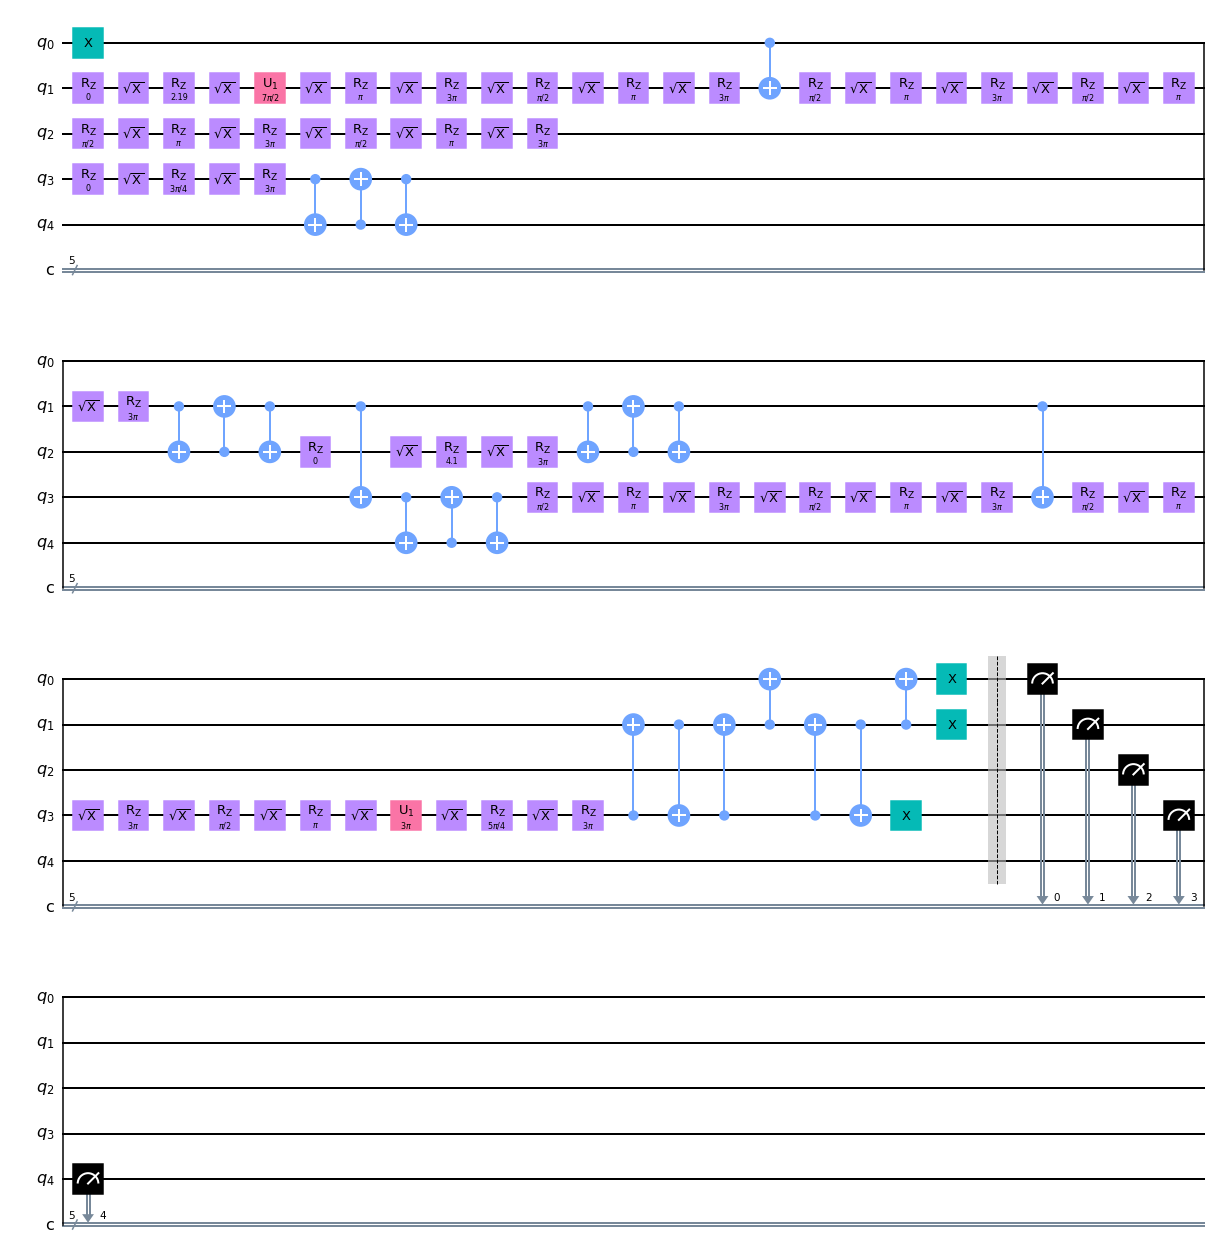

In [38]:
real_circs[i_state_test].draw(output='mpl')

## Histogram on simulator

ibmq_quito circuit # 11 on noise free simulator


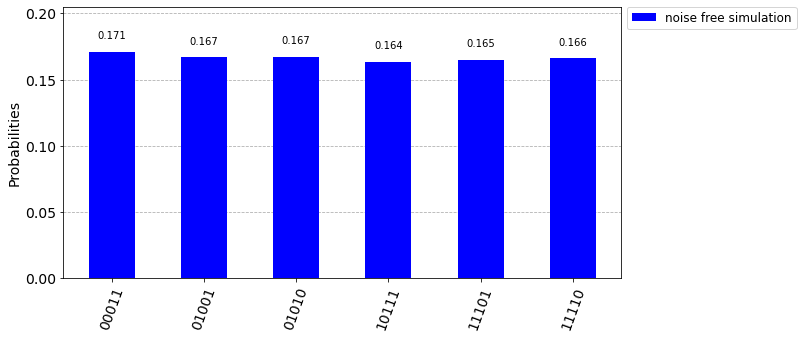

In [39]:
job_simul = execute(real_circs[i_state_test], backend=simulator, shots=s_sim)
print(project_device, "circuit #",i_state_test, "on noise free simulator")
simul_results = job_simul.result().get_counts()
plot_histogram(simul_results,
               legend=['noise free simulation'],
               color = "b", figsize=(10.,5.))

# Results on real device

### Obtain mitigation filter

In [40]:
# retrieve the corresponding measurement mitigation filter obtained at experimental time
# use a fake job because the calibration results were stored as dictionary
simulator = Aer.get_backend('qasm_simulator')
fake_job_cal = execute(meas_calibs, backend=simulator, shots=1)
fake_cal_results = fake_job_cal.result()
cal_results_dic = json_dic_loader("cal_results_dic_"+mitig_name)

In [41]:
if 'date' in cal_results_dic.keys():
    str(cal_results_dic['date'])

In [42]:
cal_results = fake_cal_results.from_dict(cal_results_dic)

In [43]:
meas_fitter = CompleteMeasFitter(cal_results, label_list, qubit_list=qubit_list, circlabel='mcal')
meas_filter = meas_fitter.filter
# have a look at the average measurement fidefily of this device:
print("Average Measurement Fidelity was: %f" % meas_fitter.readout_fidelity(), "for",project_device)

Average Measurement Fidelity was: 0.840260 for ibmq_quito


### Obtain the matrix of probability distribution of shape(nb_state,nb_labels) used by the classifier

In [44]:
empirical_dic = json_dic_loader('experimental_'+project_name)
test_dic = json_dic_loader('test_'+project_name) 

In [45]:
def rectify_counts(tot_res, test_cqi,mitigation,m_filter) :       
        
        void_counts = dict(zip(label_list, np.zeros(2**used_qubits)))
        try:
            counts_results_real_test = tot_res[test_cqi]
        except KeyError as error:            
            counts_results_real_test = tot_res[str(test_cqi)]

        raw_counts_test = copy.deepcopy(void_counts)
        raw_counts_test.update(counts_results_real_test)

        if mitigation:
            mitigated_results_test = meas_filter.apply(raw_counts_test, method = 'least_squares')
            returned_counts = copy.deepcopy(void_counts)
            returned_counts.update(mitigated_results_test)
                        
        else:
            returned_counts = copy.deepcopy(raw_counts_test)
            
        return returned_counts

In [46]:
def get_clean_matrix(dic, mitigation,m_filter):
    clean_matrix =  np.ndarray((nb_states,nb_labels)) 
    for i_state in range(nb_states):
        rectified_counts = rectify_counts(dic,i_state, mitigation,m_filter) # get a rectified counts dictionary       
        clean_matrix[i_state, :] = list(rectified_counts.values())
    clean_matrix = clean_matrix/clean_matrix.sum(axis=1, keepdims=True)
    return clean_matrix

In [47]:
def obtain_pooled_PDM(mitigation):
    PD_exper = get_clean_matrix(empirical_dic, mitigation=mitigation,
                                m_filter=meas_filter)
    PD_test = get_clean_matrix(test_dic, mitigation=mitigation,
                                m_filter=meas_filter)
    return PD_exper + PD_test

In [48]:
PD_tot = obtain_pooled_PDM(mitigation=False)/2
PD_totm = obtain_pooled_PDM(mitigation=True)/2

ibmq_quito circuit # 11 circuit depth: 70
gates =  OrderedDict([('rz', 38), ('sx', 33), ('cx', 22), ('measure', 5), ('x', 4), ('u1', 2), ('barrier', 1)])


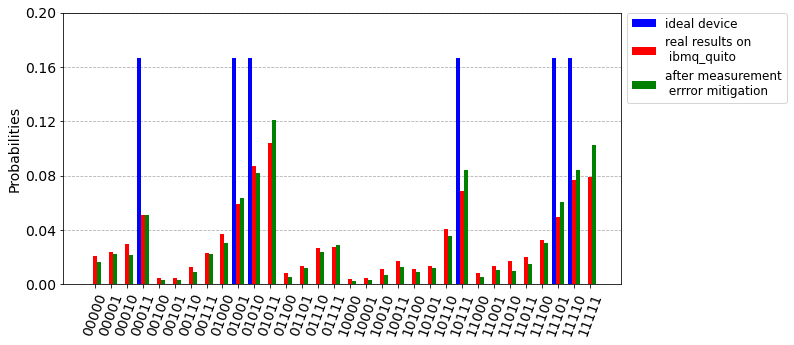

In [49]:
print(project_device, "circuit #",i_state_test,
      "circuit depth:",real_circs[i_state_test].depth())
print('gates = ',real_circs[i_state_test].count_ops())

ideal_results = dict(zip(label_list,PD_ideal[i_state_test]))
real_results = dict(zip(label_list,PD_tot[i_state_test]))
mit_results = dict(zip(label_list,PD_totm[i_state_test]))

plot_histogram([ideal_results, real_results, mit_results],
               legend=['ideal device','real results on\n '+ project_device, 'after measurement\n errror mitigation'],
               color =["b","r","g"],
               bar_labels=False,
               figsize=(10.,5.))

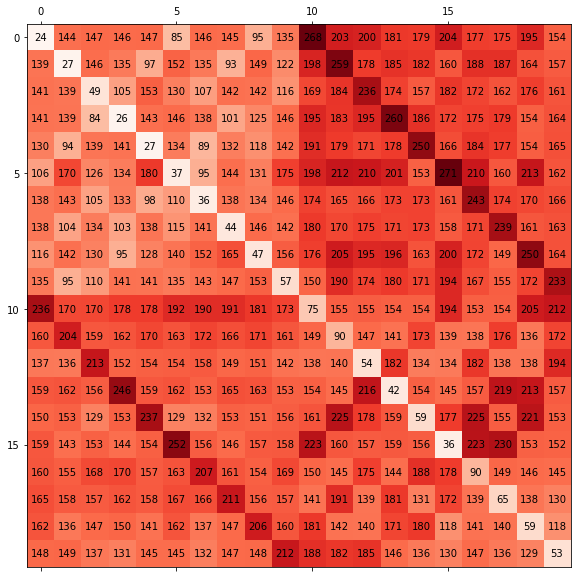

In [50]:
# Matrix of distances between distributions
# Numbers in squares are "distances expressed per thousand", thus from 0 to 1000

Y_dist_tot = cdist(PD_tot,PD_ideal, metric='sqeuclidean') 
# !cdist(1st matrix -> Y rows, 2d matrix -> Y columns)  
 
# adapted from https://stackoverflow.com/questions/40887753/display-matrix-values-and-colormap:
fig, ax = plt.subplots(figsize=(10.,10.))
figsize=(20.,20.)
min_val, max_val =  np.min(Y_dist_tot), np.max(Y_dist_tot)
ax.matshow(Y_dist_tot, cmap=plt.cm.Reds)
for i in range(20):
    for j in range(20):
        c = round(1000*Y_dist_tot[j,i])
        ax.text(i, j, str(c), va='center', ha='center')

In [51]:
import qiskit.tools.jupyter
%qiskit_version_table